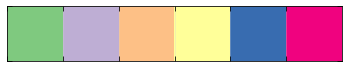

In [26]:
import numpy as np
import pandas as pd
from glob import glob
import sys
from icecube import astro
sys.path.append('/home/apizzuto/Nova/scripts/')
from Novae import Nova
import matplotlib.pyplot as plt
from astropy.time import Time
import seaborn as sns
import matplotlib as mpl
from numpy.lib.recfunctions import append_fields
plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
%matplotlib inline
palette = sns.color_palette('colorblind')
palette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
sns.palplot(palette)

In [2]:
def mids(arr):
    return arr[:-1] + (np.diff(arr) / 2.)

def find_nearest(array, values):
    array = np.asarray(array)
    idx = [(np.abs(array - value)).argmin() for value in values]
    return array[idx]

def deltaPsi(dec1, ra1, dec2, ra2):
    """
    Calculate angular distance.
    
    Args:
        dec1: Declination of first direction in radian
        ra1: Right ascension of first direction in radian
        dec2: Declination of second direction in radian
        ra2: Right ascension of second direction in radian
        
    Returns angular distance in radian
    """
    return deltaPsi2(np.sin(dec1), np.cos(dec1), np.sin(ra1), np.cos(ra1), np.sin(dec2), np.cos(dec2), np.sin(ra2), np.cos(ra2))

def deltaPsi2(sDec1, cDec1, sRa1, cRa1, sDec2, cDec2, sRa2, cRa2):
    """
    Calculate angular distance.
    
    Args:
        sDec1: sin(Declination of first direction)
        cDec1: cos(Declination of first direction)
        sRa1: sin(Right ascension of first direction)
        cRa1: cos(Right ascension of first direction)
        sDec2: sin(Declination of second direction)
        cDec2: cos(Declination of second direction)
        sRa2: sin(Right ascension of second direction)
        cRa2: cos(Right ascension of second direction)
        
    Returns angular distance in radian
    """
    tmp = cDec1*cRa1*cDec2*cRa2 + cDec1*sRa1*cDec2*sRa2 + sDec1*sDec2
    tmp[tmp>1.] = 1.
    tmp[tmp<-1.] = -1.
    return np.arccos(tmp)

In [3]:
df = pd.read_csv('/home/apizzuto/Nova/Novae_details.csv')
df = df.sort_values('Start Time (gamma ray)')

novae = []
for index, row in df.iterrows():
    a = Nova(row['Name'], -1*row['EPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['EPL flux']*1e-7, cutoff = row['EPL cutoff '])
    novae.append(a)
datafs = sorted(glob('/data/user/mlarson/combo_r129072/skylab/scripts/testing/GRECO/version-001-p00/IC86_*_data.npy'))
datas = [np.load(dataf) for dataf in datafs]
mc = np.load('/data/user/mlarson/combo_r129072/skylab/scripts/testing/GRECO/version-001-p00/IC86_2012_mc.npy')
grlfs = sorted(glob('/data/user/mlarson/combo_r129072/skylab/scripts/testing/GRECO/version-001-p00/GRL/IC86_*_data.npy'))
grls = [np.load(grlf) for grlf in grlfs]

In [6]:
def append_rows(arrayIN, NewRows):
    # Calculate the number of old and new rows
    len_arrayIN = arrayIN.shape[0]
    len_NewRows = len(NewRows)
    # Resize the old recarray
    arrayIN.resize(len_arrayIN + len_NewRows, refcheck=False)
    # Write to the end of recarray
    arrayIN[-len_NewRows:] = NewRows
    return arrayIN
    
master_grl = grls[0]
for grl in grls[1:]:
    master_grl = append_rows(master_grl, grl)
    
master_grl = np.unique(master_grl)

In [4]:
datas[0]
dpsi = deltaPsi(mc['dec'], mc['ra'], mc['trueDec'], mc['trueRa'])
mc = append_fields(mc, 'deltaPsi', dpsi, usemask=False)

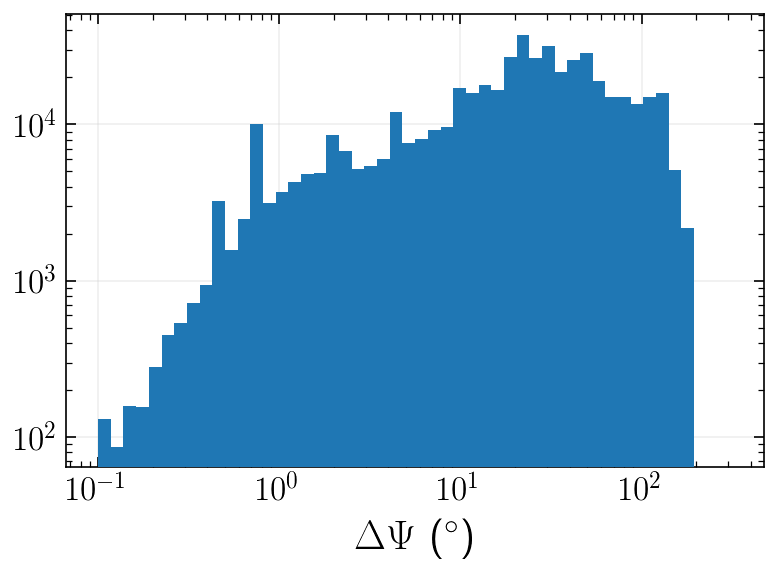

In [12]:
if True:
    bins = np.logspace(-1., 2.5, 51)
    xscale = 'log'
else:
    bins = np.linspace(0., 180., 51)
    xscale = 'linear'
fig, ax = plt.subplots(dpi=150)
plt.hist(mc['deltaPsi']*180. / np.pi, bins = bins, zorder = 20, weights = mc['ow'])
plt.xlabel(r'$\Delta \Psi$ ($^{\circ}$)', fontsize = 20)
#plt.ylabel('Number')
plt.yscale('log')
plt.xscale(xscale)
plt.show()

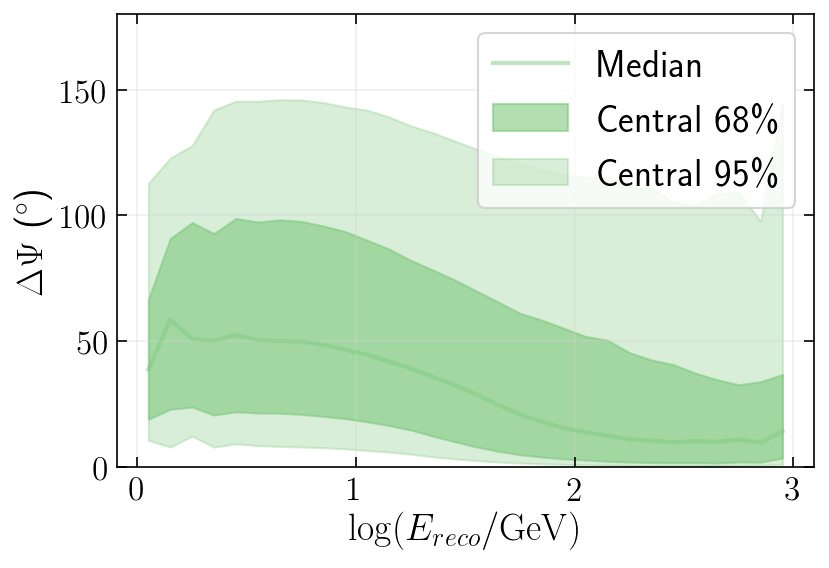

In [37]:
#reco_bins = np.unique(np.append(np.linspace(0., 3., 31), np.linspace(3., 4.5, 4)))
reco_bins = np.linspace(0., 3., 31)
low_2, low_1, meds, high_1, high_2 = [], [], [], [], []

for bl, br in zip(reco_bins[:-1], reco_bins[1:]):
    msk = mc['logE'] < br
    msk *= mc['logE'] > bl
    evs = mc[msk]
    #print len(evs)
    low_2.append(np.percentile(evs['deltaPsi'], 2.5) * 180. / np.pi)
    low_1.append(np.percentile(evs['deltaPsi'], 14.8) * 180. / np.pi)
    meds.append(np.percentile(evs['deltaPsi'], 50.) * 180. / np.pi)
    high_1.append(np.percentile(evs['deltaPsi'], 84.2) * 180. / np.pi)
    high_2.append(np.percentile(evs['deltaPsi'], 97.5) * 180. / np.pi)

fig, ax = plt.subplots(dpi=150)
bc = mids(reco_bins)
plt.plot(bc, meds, color = palette[0], label = 'Median', lw = 2., alpha = 1.5)
plt.fill_between(bc, low_1, high_1, color = palette[0], alpha = 0.6, label = 'Central 68\%')
plt.fill_between(bc, low_2, high_2, color = palette[0], alpha = 0.3, label = 'Central 95\%')
plt.xlabel(r'$\log (E_{reco} / \rm{GeV})$')
plt.ylabel(r'$\Delta \Psi$ ($^{\circ}$)')
plt.ylim(0., 180.)
plt.legend(loc=1, fontsize = 18)
plt.show()

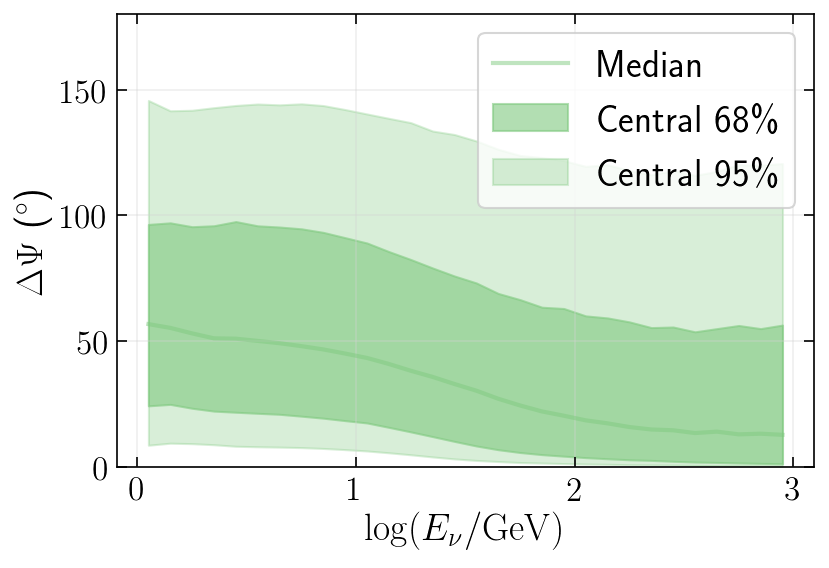

In [39]:
true_bins = np.linspace(0., 3., 31)
low_2, low_1, meds, high_1, high_2 = [], [], [], [], []

for bl, br in zip(reco_bins[:-1], reco_bins[1:]):
    msk = np.log10(mc['trueE']) < br
    msk *= np.log10(mc['trueE']) > bl
    evs = mc[msk]
    #print len(evs)
    low_2.append(np.percentile(evs['deltaPsi'], 2.5) * 180. / np.pi)
    low_1.append(np.percentile(evs['deltaPsi'], 14.8) * 180. / np.pi)
    meds.append(np.percentile(evs['deltaPsi'], 50.) * 180. / np.pi)
    high_1.append(np.percentile(evs['deltaPsi'], 84.2) * 180. / np.pi)
    high_2.append(np.percentile(evs['deltaPsi'], 97.5) * 180. / np.pi)

fig, ax = plt.subplots(dpi=150)
bc = mids(reco_bins)
plt.plot(bc, meds, color = palette[0], label = 'Median', lw = 2., alpha = 1.5)
plt.fill_between(bc, low_1, high_1, color = palette[0], alpha = 0.6, label = 'Central 68\%')
plt.fill_between(bc, low_2, high_2, color = palette[0], alpha = 0.3, label = 'Central 95\%')
plt.xlabel(r'$\log (E_{\nu} / \rm{GeV})$')
plt.ylabel(r'$\Delta \Psi$ ($^{\circ}$)')
plt.ylim(0., 180.)
plt.legend(loc=1, fontsize = 18)
plt.show()

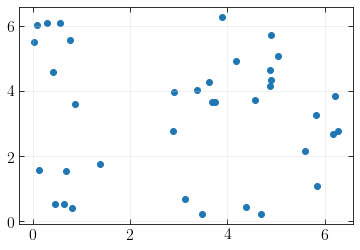

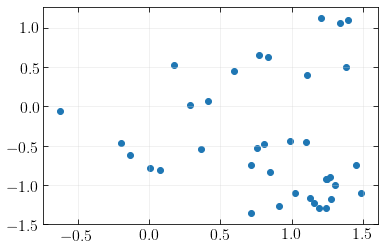

In [34]:
tst = mc[mc['logE'] > 3.]
plt.scatter(tst['ra'], tst['trueRa'])
plt.show()

plt.scatter(tst['dec'], tst['trueDec'])
plt.show()

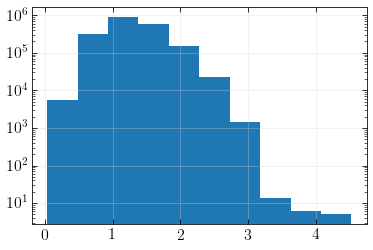

In [16]:
plt.hist(mc['logE'])
plt.yscale('log')

In [38]:
mc.dtype.names

('run',
 'event',
 'subevent',
 'time',
 'ra',
 'dec',
 'azi',
 'zen',
 'angErr',
 'logE',
 'trueE',
 'trueRa',
 'trueDec',
 'ow',
 'deltaPsi')